# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Install TensorFlow
try:
  %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Unknown TensorFlow version: only exists in Colab.
Currently selected TF version: 1.x
Available versions:
 * 1.x
 * 2.x
TensorFlow 2.x selected.


# Basic RNNs

### Generate the Dataset

In [0]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

**51개 타임스탬프 데이터의 첫 50개 데이터로 51번째 데이터 예측하기**

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


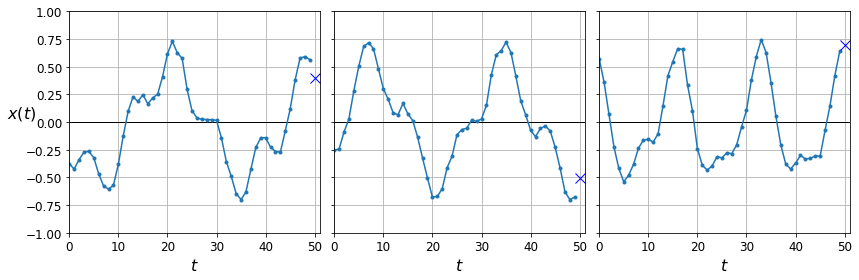

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

### Computing Some Baselines

Naive predictions (just predict the last observed value):

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

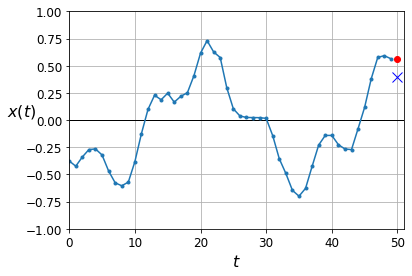

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Linear predictions:

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 3s 358us/sample - loss: 0.1004 - val_loss: 0.0559
Epoch 2/20
7000/7000 [==============================] - 1s 79us/sample - loss: 0.0386 - val_loss: 0.0269
Epoch 3/20
7000/7000 [==============================] - 1s 77us/sample - loss: 0.0205 - val_loss: 0.0162
Epoch 4/20
7000/7000 [==============================] - 1s 86us/sample - loss: 0.0133 - val_loss: 0.0118
Epoch 5/20
7000/7000 [==============================] - 1s 84us/sample - loss: 0.0104 - val_loss: 0.0098
Epoch 6/20
7000/7000 [==============================] - 1s 81us/sample - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
7000/7000 [==============================] - 1s 81us/sample - loss: 0.0080 - val_loss: 0.0078
Epoch 8/20
7000/7000 [==============================] - 1s 79us/sample - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
7000/7000 [==============================] - 1s 83us/sample - loss: 0.0066 - val_loss: 0.0065
Epoch 

In [9]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 49us/sample - loss: 0.0041


0.004145486194640398

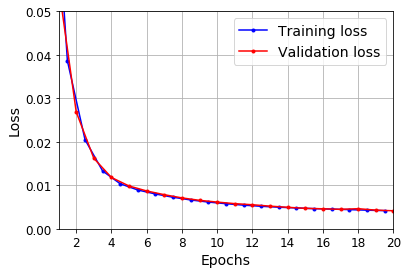

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

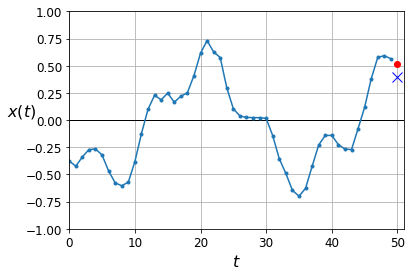

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN

h(t) = g(W1.x(t) + W2.h(t-1) + b1)

input_shape=[batch_size, time_steps, data dimension]

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0972 - val_loss: 0.0491
Epoch 2/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0372 - val_loss: 0.0298
Epoch 3/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0255 - val_loss: 0.0220
Epoch 4/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0200 - val_loss: 0.0178
Epoch 5/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0167 - val_loss: 0.0152
Epoch 6/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0147 - val_loss: 0.0135
Epoch 7/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0133 - val_loss: 0.0124
Epoch 8/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0124 - val_loss: 0.0117
Epoch 9/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0119 - val_loss: 0.0113
Epoch 10/20
7000

In [13]:
model.evaluate(X_test, y_test)

1000/1000 [==============================] - 0s 233us/sample - loss: 0.0113


0.011253698661923408

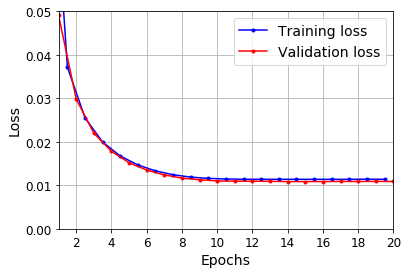

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

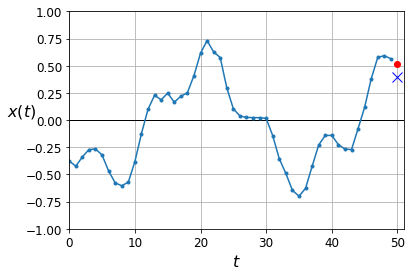

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/10
7000/7000 [==============================] - 24s 3ms/sample - loss: 0.0433 - val_loss: 0.0073
Epoch 2/10
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0066 - val_loss: 0.0052
Epoch 3/10
7000/7000 [==============================] - 22s 3ms/sample - loss: 0.0051 - val_loss: 0.0043
Epoch 4/10
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0045 - val_loss: 0.0044
Epoch 5/10
7000/7000 [==============================] - 22s 3ms/sample - loss: 0.0040 - val_loss: 0.0038
Epoch 6/10
7000/7000 [==============================] - 22s 3ms/sample - loss: 0.0038 - val_loss: 0.0042
Epoch 7/10
7000/7000 [==============================] - 22s 3ms/sample - loss: 0.0037 - val_loss: 0.0033
Epoch 8/10
7000/7000 [==============================] - 22s 3ms/sample - loss: 0.0036 - val_loss: 0.0035
Epoch 9/10
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0034 - val_loss: 0.0038
Epoch 1

In [17]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 1s 417us/sample - loss: 0.0034


0.0034210954289883373

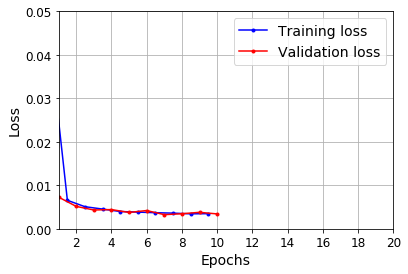

In [18]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

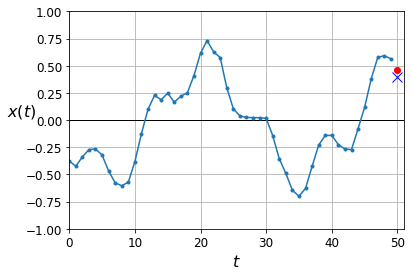

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

In [0]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [0]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


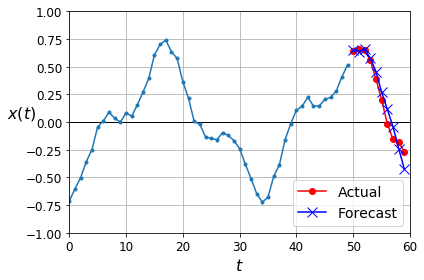

In [0]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [0]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [0]:
Y_pred.shape

(2000, 10)

In [0]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.0426335

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [0]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 1s 146us/sample - loss: 0.1348 - val_loss: 0.0610
Epoch 2/20
7000/7000 [==============================] - 1s 112us/sample - loss: 0.0501 - val_loss: 0.0427
Epoch 3/20
7000/7000 [==============================] - 1s 107us/sample - loss: 0.0388 - val_loss: 0.0356
Epoch 4/20
7000/7000 [==============================] - 1s 106us/sample - loss: 0.0334 - val_loss: 0.0314
Epoch 5/20
7000/7000 [==============================] - 1s 109us/sample - loss: 0.0299 - val_loss: 0.0286
Epoch 6/20
7000/7000 [==============================] - 1s 111us/sample - loss: 0.0275 - val_loss: 0.0264
Epoch 7/20
7000/7000 [==============================] - 1s 109us/sample - loss: 0.0258 - val_loss: 0.0251
Epoch 8/20
7000/7000 [==============================] - 1s 111us/sample - loss: 0.0245 - val_loss: 0.0237
Epoch 9/20
7000/7000 [==============================] - 1s 112us/sample - loss: 0.0235 - val_loss: 0.022

Now let's create an RNN that predicts all 10 next values at once:

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 20s 3ms/sample - loss: 0.0665 - val_loss: 0.0317
Epoch 2/20
7000/7000 [==============================] - 18s 3ms/sample - loss: 0.0268 - val_loss: 0.0221
Epoch 3/20
7000/7000 [==============================] - 18s 3ms/sample - loss: 0.0188 - val_loss: 0.0166
Epoch 4/20
7000/7000 [==============================] - 18s 3ms/sample - loss: 0.0159 - val_loss: 0.0137
Epoch 5/20
7000/7000 [==============================] - 18s 3ms/sample - loss: 0.0138 - val_loss: 0.0127
Epoch 6/20
7000/7000 [==============================] - 18s 3ms/sample - loss: 0.0132 - val_loss: 0.0117
Epoch 7/20
7000/7000 [==============================] - 18s 3ms/sample - loss: 0.0119 - val_loss: 0.0117
Epoch 8/20
7000/7000 [==============================] - 18s 3ms/sample - loss: 0.0115 - val_loss: 0.0119
Epoch 9/20
7000/7000 [==============================] - 18s 3ms/sample - loss: 0.0110 - val_loss: 0.0113
Epoch 1

KeyboardInterrupt: ignored

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

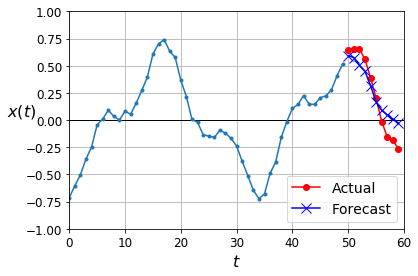

In [0]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [0]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=1,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
7000/7000 [==============================] - 20s 3ms/sample - loss: 0.0498 - last_time_step_mse: 0.0388 - val_loss: 0.0416 - val_last_time_step_mse: 0.0321


In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

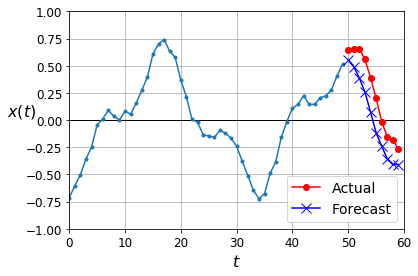

In [0]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Deep RNN with Batch Norm

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.1935 - last_time_step_mse: 0.1917 - val_loss: 0.0902 - val_last_time_step_mse: 0.0864
Epoch 2/20
7000/7000 [==============================] - 7s 957us/sample - loss: 0.0535 - last_time_step_mse: 0.0447 - val_loss: 0.0556 - val_last_time_step_mse: 0.0468
Epoch 3/20
7000/7000 [==============================] - 7s 943us/sample - loss: 0.0470 - last_time_step_mse: 0.0374 - val_loss: 0.0453 - val_last_time_step_mse: 0.0357
Epoch 4/20
7000/7000 [==============================] - 7s 947us/sample - loss: 0.0436 - last_time_step_mse: 0.0335 - val_loss: 0.0417 - val_last_time_step_mse: 0.0320
Epoch 5/20
7000/7000 [==============================] - 7s 951us/sample - loss: 0.0408 - last_time_step_mse: 0.0304 - val_loss: 0.0405 - val_last_time_step_mse: 0.0301
Epoch 6/20
7000/7000 [==============================] - 7s 956us/sample - loss: 0.0385 - last_time_step_mse: 0.02

# LSTMs

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=1,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
7000/7000 [==============================] - 5s 746us/sample - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0372


In [0]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 0s 166us/sample - loss: 0.0554 - last_time_step_mse: 0.0372


[0.0554201847910881, 0.037222918]

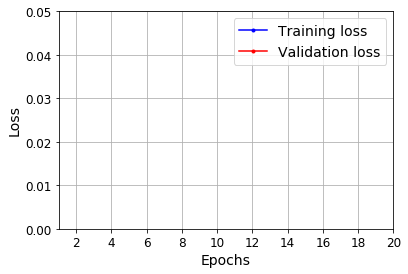

In [0]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

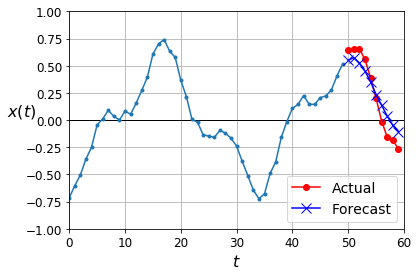

In [0]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRUs

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 17s 2ms/sample - loss: 0.0745 - last_time_step_mse: 0.0668 - val_loss: 0.0526 - val_last_time_step_mse: 0.0413
Epoch 2/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0478 - last_time_step_mse: 0.0369 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0420 - last_time_step_mse: 0.0306 - val_loss: 0.0395 - val_last_time_step_mse: 0.0275
Epoch 4/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0375 - last_time_step_mse: 0.0250 - val_loss: 0.0346 - val_last_time_step_mse: 0.0205
Epoch 5/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0327 - last_time_step_mse: 0.0178 - val_loss: 0.0311 - val_last_time_step_mse: 0.0156
Epoch 6/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0309 - last_time_step_mse: 0.0157 - 

In [0]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 0s 173us/sample - loss: 0.0554 - last_time_step_mse: 0.0372


[0.0554201847910881, 0.037222918]

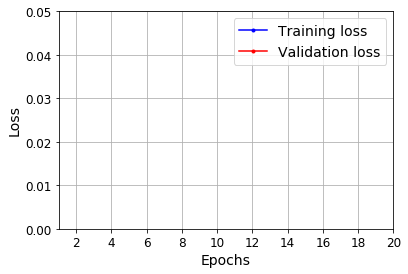

In [0]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

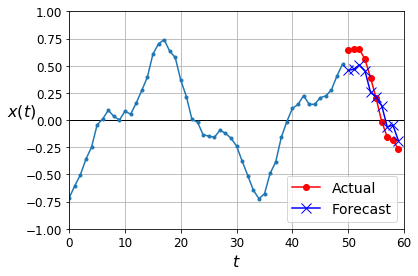

In [0]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()